# Import the Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.express as px


from scipy.optimize import minimize
import scipy.stats as ss

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from DP_Binary_split import *
from DQN_Binary_split.PortfolioRebalancerEnv_Roy import PortfolioRebalancerEnv
from datetime import datetime, timedelta


from sklearn.metrics import confusion_matrix
sns.set_theme()

In [2]:
plt.rcParams.update({"font.size": 18})
tmp_device = torch.device("cpu")

In [3]:
og_path = os.getcwd()
og_path

'/Users/Roy/Desktop/College/GeorgiaTech/Research/Portfolio-Rebalancing-DQN'

## OLD Steps:

- initialize mu and cov and init state $(w_1, w_2)$ for 2 assets
- sample from multivariate normal with mean mu and sigma cov (that would be your return) at a time step
- then given the same initialized state weights
    - policy 1 always rebalances
    - policy 2 is DQN
    - get new weights (new_state)
    - calculate what the cost is:
        - Policy 1: $c|w^* - w_0| + ObjFunc(w^*)$
            - DQN:
                - Trade/Rebalance:
                    - $c|w^* - w_0| + ObjFunc(w^*)$
                - No Rebalance/No Trade:
                    - $ObjFunc(w_1)$
    - Here $w^*$ is optimal weight, $w_0$ is current weight, $w_1$ is always optimal weight for policy 1 and either optimal weight or current weight for policy 2 depending if conditions were met
    - Update weights according to the formula:
$$ w^i_{t+1} = \frac{(1+r^i)w^i_{t}}{\sum_j (1+r)w^j_{t}}$$

# Helper Functions

In [4]:
def color_positive_green(val):
    if val > 0:
        color = 'green'
    else:
        color = 'red'
    return 'color: %s' % color

In [5]:
def sample_return(mu, cov):
    return np.random.multivariate_normal(mean=mu, cov=cov)

In [6]:
def adjust_weights(r, w):
    s = np.dot(np.add(1, r), w)
    new_weights = (np.add(1, r) * w) / s
    new_weights = np.round(new_weights, 2)
    assert np.isclose(new_weights.sum(), 1.0)
    return new_weights

In [7]:
def init_state(n_assets):
    # states from 0 to 1 and sum to 1
    state_possible = np.random.uniform(low=0, high=1, size=n_assets)
    state_possible /= state_possible.sum()
    state_possible = np.round(state_possible, 2)  # discretize the state space to avoid explosion

    return state_possible

In [8]:
# Net Sharpe Ratio
def net_sharpe(w1, mu, cov):
    """

    :param w1: next state
    :param mu: mean
    :param cov: covariance diagonal matrix
    :param w0: current state
    :param tc: transaction costs
    :return: net sharpe value
    """
    # return (w1.dot(mu) - cost_turnover(w0, w1, tc)) / np.sqrt(w1.dot(cov).dot(w1.T))
    return (w1.dot(mu)) / np.sqrt(w1.dot(cov).dot(w1.T))


# Objective Function
def obj_func(x, mu, cov):
    """
    Objective Function for the Mean Variance optimization algorithm.
    :param x: tmp weight
    :param mu: mean
    :param cov: covariance diagonal matrix
    :return:
    """
    return -x.dot(mu) / np.sqrt(x.dot(cov).dot(x))
    # return 0.5 * (x.dot(cov).dot(x)) - x.dot(mu)


# Finding Optimal Weight given mean and covariance
def find_optimal_wgt(mu, cov):
    # TODO: Should we change w_max to 1 or to 2/n ? so if n = 8 limit would be 0.25 in one asset?
    n = len(mu)
    w_min = np.zeros(n)
    w_max = np.ones(n) * 2 / n
    x0 = np.ones(n) / n
    bounds = np.vstack([w_min, w_max]).T

    cstr = [{"type": "eq", "fun": lambda x: np.sum(x) - 1, "jac": lambda x: np.ones(n)}]
    opt = minimize(fun=obj_func, x0=x0, args=(mu, cov),
                   bounds=bounds,
                   constraints=cstr,
                   tol=1e-6,
                   options={"maxiter": 10000})

    if not opt.success:
        raise ValueError("optimization failed: {}".format(opt.message))

    return opt.x / opt.x.sum()


def cost_turnover(w0, w1, tc):
    """

    :param w0: current state weights
    :param w1: next state weights
    :param tc: transaction costs
    :return: cost turnover value
    """
    return np.sum(np.abs(w1 - w0) * tc)


def expected_cost_total(w0, w1, opt_w, mu, cov, tc):
    """

    :param w0: current state weights
    :param w1: next state weights
    :param opt_w: optimal mean-variance weights
    :param mu: mean of returns
    :param cov: covariance of returns
    :param tc: transaction costs
    :return: expected cost of optimal - state net sharpe values
    """
    opt_net_sharpe = net_sharpe(w1=opt_w, mu=mu, cov=cov, w0=w0, tc=tc)
    w1_net_sharpe = net_sharpe(w1=w1, mu=mu, cov=cov, w0=w0, tc=tc)
    return opt_net_sharpe - w1_net_sharpe

# Initialize DQN

In [9]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, name, tc, chkpt_dir='results/models'):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, n_actions)

        self.checkpoint_file = os.path.join(chkpt_dir, name + f'_tc_{tc}_assets_{n_observations}_dqn')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file, map_location=torch.device('cpu')))

In [10]:
def load_models(pn, tn):
    pn.load_checkpoint()
    tn.load_checkpoint()

In [11]:
ddpg_path = og_path + '/DQN_Binary_split/'
os.chdir(ddpg_path)

# Initialize constants

In [12]:
n_asset = 2
mu = np.linspace(50, 200, n_asset) / 1e4
sigma = np.linspace(300, 800, n_asset) / 1e4
cov = np.diag(sigma ** 2)
tc_list = [0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05]

# tc_list = [0, 0.0001, 0.0002, 0.0003,
#            0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]

In [13]:
optimal_weight = find_optimal_wgt(mu, cov).round(2)
optimal_weight

array([0.64, 0.36])

In [14]:
scaling_factor = 252/5
env = PortfolioRebalancerEnv(
    mu=mu,
    sigma=cov,
    w_optimal=optimal_weight,
    n_assets=n_asset,
    scaling_factor=scaling_factor
)
# device = torch.device("cpu")

## DQN Result

In [15]:
# init state
state = init_state(n_assets=n_asset)
state

array([0.06, 0.94])

In [16]:
state.shape

(2,)

In [17]:
dqn_models = {}

for tc in tc_list:
    a = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)
    b = DQN(n_observations=n_asset, n_actions=2, name="Policy", tc=tc).to(tmp_device)

    load_models(pn=a, tn=b)
    dqn_models[f"TC: {tc * 1e4:.0f} bps"] = a

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


In [18]:
N = 365*5

In [19]:
opt_obj = obj_func(x=optimal_weight, mu=mu, cov=cov)
opt_obj

-0.3004626062886657

# DP Model

In [20]:
ddpg_path = og_path + '/DP_Binary_split/'
os.chdir(ddpg_path)

In [21]:
df_list = []
for tc in tc_list:
    tmp_df = pd.read_csv(f"results/models/dp_tc_{tc}_assets_2", index_col=0, dtype=np.float32)
    if tmp_df.empty:
        print(tc)
    df_list.append(tmp_df)

In [22]:
dp_dict = {f"TC: {tc * 1e4:.0f} bps":v for v,tc in zip(df_list, tc_list)}

# New Breakdown as of Nov 1st, 2023

- retrained DQN and DP on objective function (Sharpe without cost turnover) + cost turnover as cost
- Policy 1: Always rebalance to optimal
- Policy 2: Only rebalance if $|w^* - w_0| > 0.01$
- Policy 3: Never rebalance (buy and hold)
- Policy 4: Single period optimal (greedy) -> take $min(c|w^* - w_0| + Sharpe(w*), Sharpe(w_0))$

In [23]:
p1_cost_tc = []
p2_cost_tc = []
p3_cost_tc = []
p4_cost_tc = []
p1_cost_obj = []
p2_cost_obj = []
p3_cost_obj = []
p4_cost_obj = []
p4_cost_total = []

dqn_cost_obj = []
dqn_cost_tc = []

dp_cost_obj = []
dp_cost_tc = []

dqn_action = []
dp_action = []

weights_p1_list = []
weights_p2_list = []
weights_p3_list = []
weights_p4_list = []
weights_dp_list = []
weights_dqn_list = []

In [24]:
# init weights
p1_weights = init_state(n_assets=n_asset) # current state
p1_weights = pd.DataFrame(p1_weights)
p1_weights = pd.concat([p1_weights] * len(tc_list), axis=1)
p1_weights.columns = [f"TC: {tc * 1e4:.0f} bps" for tc in tc_list]

# initialize rest of weights the same way
p2_weights = p1_weights.copy(deep=True)
p3_weights = p1_weights.copy(deep=True)
p4_weights = p1_weights.copy(deep=True)
dp_weights = p1_weights.copy(deep=True)
dqn_weights = p1_weights.copy(deep=True)


In [25]:
p1_weights

TC: 0 bps  TC: 5 bps  TC: 10 bps  TC: 20 bps  TC: 50 bps  TC: 100 bps  \
0       0.41       0.41        0.41        0.41        0.41         0.41   
1       0.59       0.59        0.59        0.59        0.59         0.59   

   TC: 500 bps  
0         0.41  
1         0.59

In [26]:
asset_returns = []
p4_tc_cumsum = {k: [] for k in p1_weights.columns}

In [27]:
for i in range(N):
    dqn_action_dict = {}
    dp_action_dict = {}
    
    weights_p1_dict = {}
    weights_p2_dict = {}
    weights_p3_dict = {}
    weights_p4_dict = {}
    weights_dqn_dict = {}
    weights_dp_dict = {}
    
    dqn_cost_dict_tc = {}
    dqn_cost_dict_obj = {}
    
    dp_cost_dict_tc = {}
    dp_cost_dict_obj = {}
    
    policy1_cost_dict_tc = {}
    policy2_cost_dict_tc = {}
    policy3_cost_dict_tc = {}
    policy4_cost_dict_tc = {}
    policy1_cost_dict_obj = {}
    policy2_cost_dict_obj = {}
    policy3_cost_dict_obj = {}
    policy4_cost_dict_obj = {}
    policy4_cost_dict_total = {}
    ret =  sample_return(mu=mu, cov=cov) # return sampled  # np.array([0, 0])
    asset_returns.append(ret)

    for tc in tc_list:

        # move weights based on market movement
        #Policy1
        p1_weights[f"TC: {tc * 1e4:.0f} bps"] = adjust_weights(r=ret, w=p1_weights[f"TC: {tc * 1e4:.0f} bps"])
        #Policy2
        p2_weights[f"TC: {tc * 1e4:.0f} bps"] = adjust_weights(r=ret, w=p2_weights[f"TC: {tc * 1e4:.0f} bps"])
        #Policy3
        p3_weights[f"TC: {tc * 1e4:.0f} bps"] = adjust_weights(r=ret, w=p3_weights[f"TC: {tc * 1e4:.0f} bps"])
        #Policy4
        p4_weights[f"TC: {tc * 1e4:.0f} bps"] = adjust_weights(r=ret, w=p4_weights[f"TC: {tc * 1e4:.0f} bps"])
        # DQN
        dqn_weights[f"TC: {tc * 1e4:.0f} bps"] = adjust_weights(r=ret, w=dqn_weights[f"TC: {tc * 1e4:.0f} bps"])
        # DP
        dp_weights[f"TC: {tc * 1e4:.0f} bps"] = adjust_weights(r=ret, w=dp_weights[f"TC: {tc * 1e4:.0f} bps"])

        
        # Policy 1:
        # always rebalance
        next_state_p1 = optimal_weight
        cost_policy1_tc = cost_turnover(w0=p1_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_p1, tc=tc) * scaling_factor
        # cost_policy1_obj = opt_obj
        # cost_policy1_obj = -expected_cost_total(w0=p1_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_p1,
        #                                             opt_w=optimal_weight, mu=mu, cov=cov, tc=tc)
        cost_policy1_obj = net_sharpe(w1=next_state_p1, mu=mu, cov=cov)

        # Policy 2:
        # only rebalance if |w* - w0| > 0.01
        if np.all(abs(optimal_weight - p2_weights[f"TC: {tc * 1e4:.0f} bps"]) > 0.01):
            next_state_p2 = optimal_weight
            cost_policy2_tc = cost_turnover(w0=p2_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_p2, tc=tc) * scaling_factor
            # cost_policy2_obj = opt_obj
        else:
            next_state_p2 = p2_weights[f"TC: {tc * 1e4:.0f} bps"]
            cost_policy2_tc = 0.0
            # cost_policy2_obj = obj_func(x=next_state_p2, mu=mu, cov=cov)

        # cost_policy2_obj = -expected_cost_total(w0=p2_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_p2,
        #                                             opt_w=optimal_weight, mu=mu, cov=cov, tc=tc)

        cost_policy2_obj = net_sharpe(w1=next_state_p2, mu=mu, cov=cov)
        
        # Policy 3:
        # never rebalance (buy and hold)
        next_state_p3 = p3_weights[f"TC: {tc * 1e4:.0f} bps"]
        cost_policy3_tc = 0.0
        # cost_policy3_obj = obj_func(x=next_state_p3, mu=mu, cov=cov)

        # cost_policy3_obj = -expected_cost_total(w0=p3_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_p3,
        #                                             opt_w=optimal_weight, mu=mu, cov=cov, tc=tc)
        cost_policy3_obj = net_sharpe(w1=next_state_p3, mu=mu, cov=cov)

        # Policy 4:
        # single period optimal (greedy)
        # take min(c|w* - w0| + ObjFunc(w*), ObjFunc(w0))
        # take max(Obj(w0), Obj(rebalance to optimal))

        # TODO: Fix Policy 4 TC CumSUM Objective
        
        tmp_cost = cost_turnover(w0=p4_weights[f"TC: {tc * 1e4:.0f} bps"], w1=optimal_weight, tc=tc) * scaling_factor
        p4_tc_cumsum[f"TC: {tc * 1e4:.0f} bps"].append(tmp_cost)
        # obj_4 = obj_func(x=p4_weights[f"TC: {tc * 1e4:.0f} bps"], mu=mu, cov=cov)
        # obj_4_noreb = -expected_cost_total(w0=p4_weights[f"TC: {tc * 1e4:.0f} bps"], w1=p4_weights[f"TC: {tc * 1e4:.0f} bps"],
        #                                             opt_w=optimal_weight, mu=mu, cov=cov, tc=tc)
        # obj_4_reb = -expected_cost_total(w0=p4_weights[f"TC: {tc * 1e4:.0f} bps"], w1=optimal_weight,
        #                                             opt_w=optimal_weight, mu=mu, cov=cov, tc=tc)
        
        obj_4_noreb = net_sharpe(w1=p4_weights[f"TC: {tc * 1e4:.0f} bps"], mu=mu, cov=cov)
        obj_4_reb = net_sharpe(w1=optimal_weight, mu=mu, cov=cov) 

        cost_policy4_obj = max(obj_4_noreb, obj_4_reb - tmp_cost)

        # cost_policy4_total = max(obj_4_noreb, obj_4_reb - np.sum(p4_tc_cumsum[f"TC: {tc * 1e4:.0f} bps"]))
        cost_policy4_total = cost_policy4_obj.copy()  # NOTE: I changed this to obj because the cumsum was not working as intended

        if cost_policy4_total == obj_4_noreb:
            next_state_p4 = p4_weights[f"TC: {tc * 1e4:.0f} bps"]
            cost_policy4_tc = 0.0
            p4_tc_cumsum[f"TC: {tc * 1e4:.0f} bps"].pop(-1)
        else:
            next_state_p4 = optimal_weight
            cost_policy4_tc = cost_turnover(w0=p4_weights[f"TC: {tc * 1e4:.0f} bps"], w1=optimal_weight, tc=tc) * scaling_factor
        
        # if tmp_cost + opt_obj < obj_4:
        #     next_state_p4 = optimal_weight
        #     cost_policy4_tc = tmp_cost
        #     # cost_policy4_obj = opt_obj
        # else:
        #     next_state_p4 = p4_weights[f"TC: {tc * 1e4:.0f} bps"]
        #     cost_policy4_tc = 0.0
        #     # cost_policy4_obj = obj_4

        # cost_policy4_obj = -expected_cost_total(w0=p4_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_p4,
        #                                             opt_w=optimal_weight, mu=mu, cov=cov, tc=tc)

        # DQN
        # take action
        model = dqn_models[f"TC: {tc * 1e4:.0f} bps"]
        qval = model(torch.FloatTensor(dqn_weights[f"TC: {tc * 1e4:.0f} bps"])).detach().numpy()
        action = (env.action_space[qval.argmax()]).item()

        # rebalance
        if action == 1:
            next_state_dqn = optimal_weight # rebalance to optimal
            cost_dqn_tc = cost_turnover(w0=dqn_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_dqn, tc=tc) * scaling_factor
            # cost_dqn_obj = opt_obj
        # no rebalance
        else:
            next_state_dqn = dqn_weights[f"TC: {tc * 1e4:.0f} bps"]
            cost_dqn_tc = 0
            # cost_dqn_obj = obj_func(x=next_state_dqn, mu=mu, cov=cov)

        # cost_dqn_obj = -expected_cost_total(w0=dqn_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_dqn,
        #                                             opt_w=optimal_weight, mu=mu, cov=cov, tc=tc)

        cost_dqn_obj = net_sharpe(w1=next_state_dqn, mu=mu, cov=cov)
        
        # DP
        # take action
        model = dp_dict[f"TC: {tc * 1e4:.0f} bps"]
        action_dp = model.loc[dp_weights[f"TC: {tc * 1e4:.0f} bps"][0]].argmax()

        # rebalance
        if action_dp == 1:
            next_state_dp = optimal_weight # rebalance to optimal
            cost_dp_tc = cost_turnover(w0=dp_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_dp, tc=tc) * scaling_factor
            # cost_dqn_obj = opt_obj
        # no rebalance
        else:
            next_state_dp = dp_weights[f"TC: {tc * 1e4:.0f} bps"]
            cost_dp_tc = 0
            # cost_dqn_obj = obj_func(x=next_state_dp, mu=mu, cov=cov)

        # cost_dp_obj = -expected_cost_total(w0=dp_weights[f"TC: {tc * 1e4:.0f} bps"], w1=next_state_dp,
        #                                             opt_w=optimal_weight, mu=mu, cov=cov, tc=tc)

        cost_dp_obj = net_sharpe(w1=next_state_dp, mu=mu, cov=cov)

        # move weights based on market movement
        #Policy1
        p1_weights[f"TC: {tc * 1e4:.0f} bps"] = next_state_p1
        #Policy2
        p2_weights[f"TC: {tc * 1e4:.0f} bps"] = next_state_p2
        #Policy3
        p3_weights[f"TC: {tc * 1e4:.0f} bps"] = next_state_p3
        #Policy4
        p4_weights[f"TC: {tc * 1e4:.0f} bps"] = next_state_p4
        # DQN
        dqn_weights[f"TC: {tc * 1e4:.0f} bps"] = next_state_dqn
        # DP
        dp_weights[f"TC: {tc * 1e4:.0f} bps"] = next_state_dp

        # if any(next_state_dp != next_state_dqn):
        #     print(next_state_dp, next_state_dqn)
        #     print(cost_dqn_tc, cost_dp_tc)
        

        # store values
        policy1_cost_dict_tc[f"TC: {tc * 1e4:.0f} bps"] = cost_policy1_tc
        policy2_cost_dict_tc[f"TC: {tc * 1e4:.0f} bps"] = cost_policy2_tc
        policy3_cost_dict_tc[f"TC: {tc * 1e4:.0f} bps"] = cost_policy3_tc
        policy4_cost_dict_tc[f"TC: {tc * 1e4:.0f} bps"] = cost_policy4_tc
        policy1_cost_dict_obj[f"TC: {tc * 1e4:.0f} bps"] = cost_policy1_obj
        policy2_cost_dict_obj[f"TC: {tc * 1e4:.0f} bps"] = cost_policy2_obj
        policy3_cost_dict_obj[f"TC: {tc * 1e4:.0f} bps"] = cost_policy3_obj
        policy4_cost_dict_obj[f"TC: {tc * 1e4:.0f} bps"] = cost_policy4_obj
        policy4_cost_dict_total[f"TC: {tc * 1e4:.0f} bps"] = cost_policy4_total
        
        dqn_cost_dict_tc[f"TC: {tc * 1e4:.0f} bps"] = cost_dqn_tc
        dqn_cost_dict_obj[f"TC: {tc * 1e4:.0f} bps"] = cost_dqn_obj
        dp_cost_dict_tc[f"TC: {tc * 1e4:.0f} bps"] = cost_dp_tc
        dp_cost_dict_obj[f"TC: {tc * 1e4:.0f} bps"] = cost_dp_obj
        
        weights_p1_dict[f"TC: {tc * 1e4:.0f} bps"] = p1_weights[f"TC: {tc * 1e4:.0f} bps"]
        weights_p2_dict[f"TC: {tc * 1e4:.0f} bps"] = p2_weights[f"TC: {tc * 1e4:.0f} bps"]
        weights_p3_dict[f"TC: {tc * 1e4:.0f} bps"] = p3_weights[f"TC: {tc * 1e4:.0f} bps"]
        weights_p4_dict[f"TC: {tc * 1e4:.0f} bps"] = p4_weights[f"TC: {tc * 1e4:.0f} bps"]
        weights_dqn_dict[f"TC: {tc * 1e4:.0f} bps"] = dqn_weights[f"TC: {tc * 1e4:.0f} bps"]
        weights_dp_dict[f"TC: {tc * 1e4:.0f} bps"] = dp_weights[f"TC: {tc * 1e4:.0f} bps"]
        
        dqn_action_dict[f"TC: {tc * 1e4:.0f} bps"] = action
        dp_action_dict[f"TC: {tc * 1e4:.0f} bps"] = action_dp

    p1_cost_tc.append(policy1_cost_dict_tc)
    p2_cost_tc.append(policy2_cost_dict_tc)
    p3_cost_tc.append(policy3_cost_dict_tc)
    p4_cost_tc.append(policy4_cost_dict_tc)
    p1_cost_obj.append(policy1_cost_dict_obj)
    p2_cost_obj.append(policy2_cost_dict_obj)
    p3_cost_obj.append(policy3_cost_dict_obj)
    p4_cost_obj.append(policy4_cost_dict_obj)
    p4_cost_total.append(policy4_cost_dict_total)
    
    
    dqn_cost_tc.append(dqn_cost_dict_tc)
    dqn_cost_obj.append(dqn_cost_dict_obj)
    
    dp_cost_tc.append(dp_cost_dict_tc)
    dp_cost_obj.append(dp_cost_dict_obj)
    
    dqn_action.append(dqn_action_dict)
    dp_action.append(dp_action_dict)
    
    weights_p1_list.append(weights_p1_dict)
    weights_p2_list.append(weights_p2_dict)
    weights_p3_list.append(weights_p3_dict)
    weights_p4_list.append(weights_p4_dict)
    weights_dqn_list.append(weights_dqn_dict)
    weights_dp_list.append(weights_dp_dict)

p1_cost_tc = pd.DataFrame(p1_cost_tc)
p2_cost_tc = pd.DataFrame(p2_cost_tc)
p3_cost_tc = pd.DataFrame(p3_cost_tc)
p4_cost_tc = pd.DataFrame(p4_cost_tc)
p1_cost_obj = pd.DataFrame(p1_cost_obj)
p2_cost_obj = pd.DataFrame(p2_cost_obj)
p3_cost_obj = pd.DataFrame(p3_cost_obj)
p4_cost_obj = pd.DataFrame(p4_cost_obj)
p4_cost_total = pd.DataFrame(p4_cost_total)

dqn_cost_tc = pd.DataFrame(dqn_cost_tc)
dqn_cost_obj = pd.DataFrame(dqn_cost_obj)

dp_cost_tc = pd.DataFrame(dp_cost_tc)
dp_cost_obj = pd.DataFrame(dp_cost_obj)

dqn_action = pd.DataFrame(dqn_action)
dp_action = pd.DataFrame(dp_action)

weights_p1_list = pd.DataFrame(weights_p1_list)
weights_p2_list = pd.DataFrame(weights_p2_list)
weights_p3_list = pd.DataFrame(weights_p3_list)
weights_p4_list = pd.DataFrame(weights_p4_list)
weights_dqn_list = pd.DataFrame(weights_dqn_list)
weights_dp_list = pd.DataFrame(weights_dp_list)


In [28]:
next_state_dp

0    0.02
1    0.98
Name: TC: 500 bps, dtype: float64

In [29]:
df1_tc = p1_cost_tc.copy(deep=True)
df1_tc.columns = [i + " (p1_tc)" for i in p1_cost_tc.columns]

df2_tc = p2_cost_tc.copy(deep=True)
df2_tc.columns = [i + " (p2_tc)" for i in p2_cost_tc.columns]

df3_tc = p3_cost_tc.copy(deep=True)
df3_tc.columns = [i + " (p3_tc)" for i in p3_cost_tc.columns]

df4_tc = p4_cost_tc.copy(deep=True)
df4_tc.columns = [i + " (p4_tc)" for i in p4_cost_tc.columns]

df1_obj = p1_cost_obj.copy(deep=True)
df1_obj.columns = [i + " (p1_obj)" for i in p1_cost_obj.columns]

df2_obj = p2_cost_obj.copy(deep=True)
df2_obj.columns = [i + " (p2_obj)" for i in p2_cost_obj.columns]

df3_obj = p3_cost_obj.copy(deep=True)
df3_obj.columns = [i + " (p3_obj)" for i in p3_cost_obj.columns]

df4_obj = p4_cost_obj.copy(deep=True)
df4_obj.columns = [i + " (p4_obj)" for i in p4_cost_obj.columns]


df_dqn_tc = dqn_cost_tc.copy(deep=True)
df_dqn_tc.columns = [i + " (dqn_tc)" for i in df_dqn_tc.columns]

df_dqn_obj = dqn_cost_obj.copy(deep=True)
df_dqn_obj.columns = [i + " (dqn_obj)" for i in df_dqn_obj.columns]

df_dp_tc = dp_cost_tc.copy(deep=True)
df_dp_tc.columns = [i + " (dp_tc)" for i in df_dp_tc.columns]

df_dp_obj = dp_cost_obj.copy(deep=True)
df_dp_obj.columns = [i + " (dp_obj)" for i in df_dp_obj.columns]

df_list = [df_dqn_tc, df_dp_tc, df1_tc, df2_tc, df3_tc, df4_tc, df_dqn_obj, df_dp_obj, df1_obj, df2_obj, df3_obj, df4_obj]
df = pd.concat(df_list, axis=1).reset_index(drop=True)

In [30]:
def create_total_df(d1, d2, name, cumul=False):
    if cumul:
        return pd.DataFrame(d1.expanding().mean().values - d2.cumsum().values,
                        columns= [i.replace(f"{name}_obj", f"{name}_total") for i in d1.columns])
    return pd.DataFrame(d1.values - d2.values,
                        columns= [i.replace(f"{name}_obj", f"{name}_total") for i in d1.columns])

In [31]:
# add total objective
df_dqn_total = create_total_df(d1=df_dqn_obj, d2=df_dqn_tc, name='dqn')

df_dp_total = create_total_df(d1=df_dp_obj, d2=df_dp_tc, name='dp')
df1_total = create_total_df(d1=df1_obj, d2=df1_tc, name='p1')
df2_total = create_total_df(d1=df2_obj, d2=df2_tc, name='p2')
df3_total = create_total_df(d1=df3_obj, d2=df3_tc, name='p3')

df4_total = p4_cost_total.copy(deep=True)
df4_total.columns = [i + " (p4_total)" for i in p4_cost_total.columns]

df_list = [df, df_dqn_total, df_dp_total, df1_total, df2_total, df3_total, df4_total]
df = pd.concat(df_list, axis=1).reset_index(drop=True)

df.head().style.applymap(color_positive_green)

## Convert to time series

In [32]:
start_date = datetime.today() - timedelta(days=N)  # Assuming today is the current date
date_index = [start_date + timedelta(days=i) for i in range(N)]
df.index = date_index
df.index = df.index.date

## TC = 0 bps

In [33]:
tc = tc_list[0]
str_check = f"TC: {tc * 1e4:.0f} bps"
df_0 = df.iloc[:, df.columns.str.contains(str_check)]
df_0.head().style.applymap(color_positive_green)

In [34]:
df_0.describe().style.applymap(color_positive_green)

In [35]:
total_df_0 = df_0[[i for i in df_0.columns if "total" in i]]
total_df_0.index = date_index
df_grouped_0 = total_df_0.groupby([total_df_0.index.year]).mean()

In [36]:
df_grouped_0

TC: 0 bps (dqn_total)  TC: 0 bps (dp_total)  TC: 0 bps (p1_total)  \
2018               0.300463              0.300463              0.300463   
2019               0.300463              0.300463              0.300463   
2020               0.300463              0.300463              0.300463   
2021               0.300463              0.300463              0.300463   
2022               0.300463              0.300463              0.300463   
2023               0.300463              0.300463              0.300463   

      TC: 0 bps (p2_total)  TC: 0 bps (p3_total)  TC: 0 bps (p4_total)  
2018              0.300463              0.277963              0.300463  
2019              0.300463              0.255778              0.300463  
2020              0.300463              0.251450              0.300463  
2021              0.300463              0.251350              0.300463  
2022              0.300463              0.251288              0.300463  
2023              0.300463              0.251317              0.300463

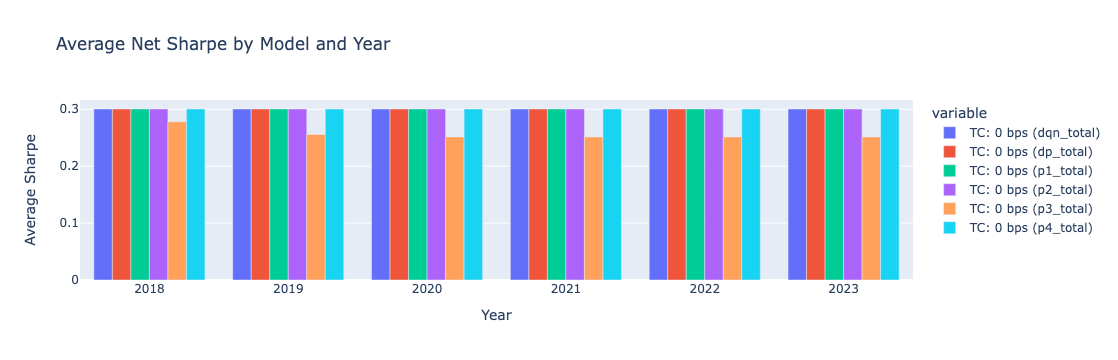

In [37]:
fig = px.bar(df_grouped_0, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

## TC = 5 bps

In [38]:
tc = tc_list[1]
str_check = f"TC: {tc * 1e4:.0f} bps"
df_1 = df.iloc[:, df.columns.str.contains(str_check)]
df_1.head().style.applymap(color_positive_green)

In [39]:
# df_1.style.applymap(color_positive_green)

In [40]:
df_1.describe().style.applymap(color_positive_green)

In [41]:
df_1.iloc[:, :6].sum()

TC: 5 bps (dqn_tc)    0.480312
TC: 5 bps (dp_tc)     0.507024
TC: 5 bps (p1_tc)     1.434888
TC: 5 bps (p2_tc)     1.434888
TC: 5 bps (p3_tc)     0.000000
TC: 5 bps (p4_tc)     0.507024
dtype: float64

In [42]:
total_df_1 = df_1[[i for i in df_1.columns if "total" in i]]
total_df_1.index = date_index
df_grouped_1 = total_df_1.groupby([total_df_1.index.year]).mean()

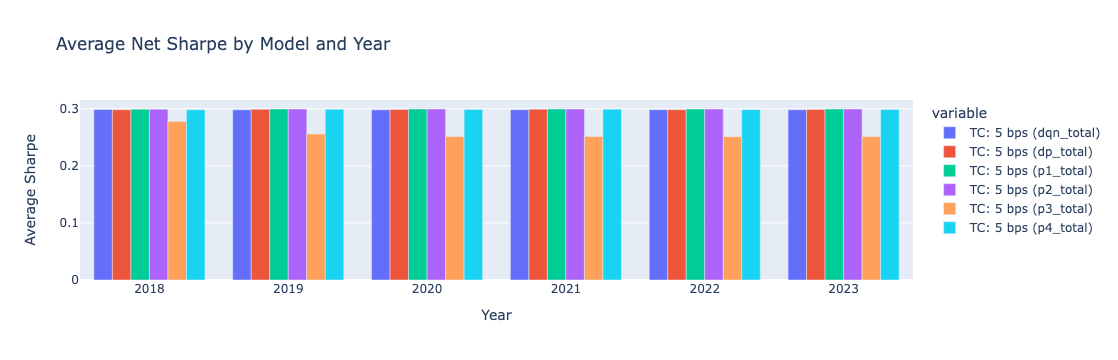

In [43]:
fig = px.bar(df_grouped_1, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

## TC = 10 bps

In [44]:
tc = tc_list[2]
str_check = f"TC: {tc * 1e4:.0f} bps"
df_2 = df.iloc[:, df.columns.str.contains(str_check)]
df_2.head().style.applymap(color_positive_green)

In [45]:
df_2.describe().style.applymap(color_positive_green)

In [46]:
total_df_2 = df_2[[i for i in df_2.columns if "total" in i]]
total_df_2.index = date_index
df_grouped_2 = total_df_2.groupby([total_df_2.index.year]).mean()

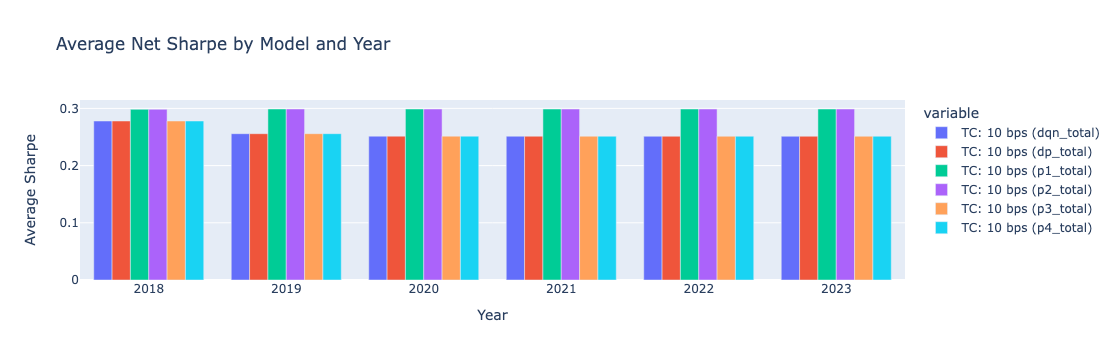

In [47]:
fig = px.bar(df_grouped_2, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

## TC = 20 bps

In [48]:
tc = tc_list[3]
str_check = f"TC: {tc * 1e4:.0f} bps"
df_3 = df.iloc[:, df.columns.str.contains(str_check)]
df_3.head().style.applymap(color_positive_green)

In [49]:
df_3.describe().style.applymap(color_positive_green)

In [50]:
total_df_3 = df_3[[i for i in df_3.columns if "total" in i]]
total_df_3.index = date_index
df_grouped_3 = total_df_3.groupby([total_df_3.index.year]).mean()

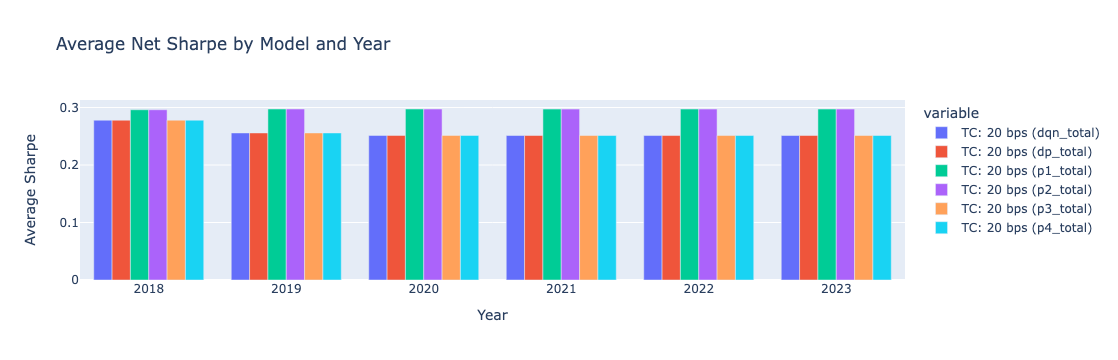

In [51]:
fig = px.bar(df_grouped_3, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

## TC = 50 bps

In [52]:
tc = tc_list[4]
str_check = f"TC: {tc * 1e4:.0f} bps"
df_4 = df.iloc[:, df.columns.str.contains(str_check)]
df_4.head().style.applymap(color_positive_green)

In [53]:
df_4.describe().style.applymap(color_positive_green)

In [54]:
total_df_4 = df_4[[i for i in df_4.columns if "total" in i]]
total_df_4.index = date_index
df_grouped_4 = total_df_4.groupby([total_df_4.index.year]).mean()

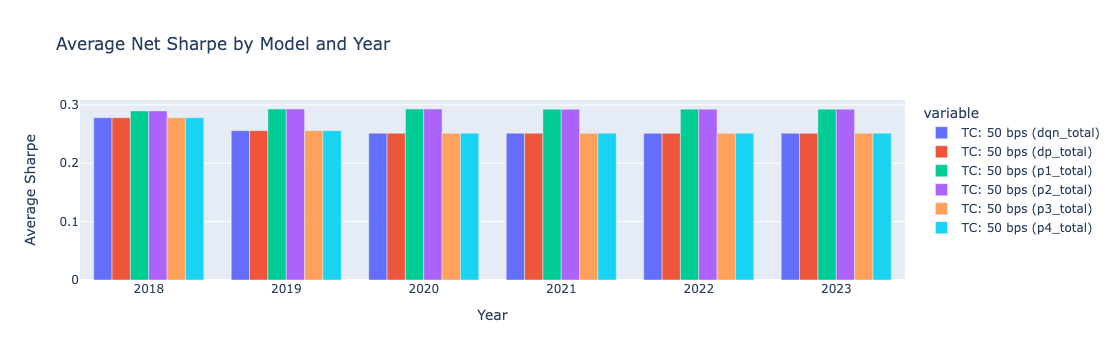

In [55]:
fig = px.bar(df_grouped_4, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

<!-- DQN, Buy and Hold, Greedy policies performed the worst here with TC = 50 bps. -->

## TC = 100 bps

In [56]:
tc = tc_list[5]
str_check = f"TC: {tc * 1e4:.0f} bps"
df_5 = df.iloc[:, df.columns.str.contains(str_check)]
df_5.head().style.applymap(color_positive_green)

In [57]:
df_5.describe().style.applymap(color_positive_green)

In [58]:
total_df_5 = df_5[[i for i in df_5.columns if "total" in i]]
total_df_5.index = date_index
df_grouped_5 = total_df_5.groupby([total_df_5.index.year]).mean()

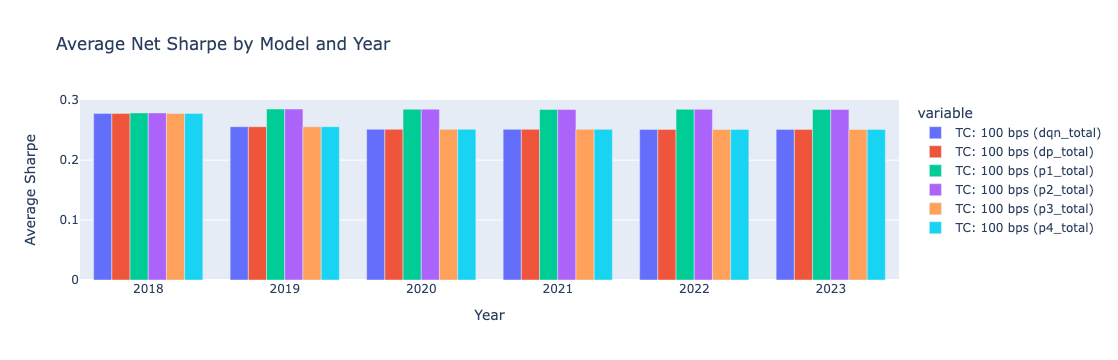

In [59]:
fig = px.bar(df_grouped_5, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

<!-- DQN, Buy and Hold, Greedy policies performed the worst here with TC = 100 bps. -->

## TC = 500 bps

In [60]:
tc = tc_list[6]
str_check = f"TC: {tc * 1e4:.0f} bps"
df_6 = df.iloc[:, df.columns.str.contains(str_check)]
df_6.head().style.applymap(color_positive_green)

In [61]:
# df_6.rolling(window=1).sum()[:20].dropna().style.applymap(color_positive_green)

In [62]:
df_6.describe().style.applymap(color_positive_green)

In [63]:
total_df_6 = df_6[[i for i in df_6.columns if "total" in i]]
total_df_6.index = date_index
df_grouped_6 = total_df_6.groupby([total_df_6.index.year]).mean()
# df_grouped_6 = total_df_6.groupby(pd.Grouper(freq='Y')).sum()

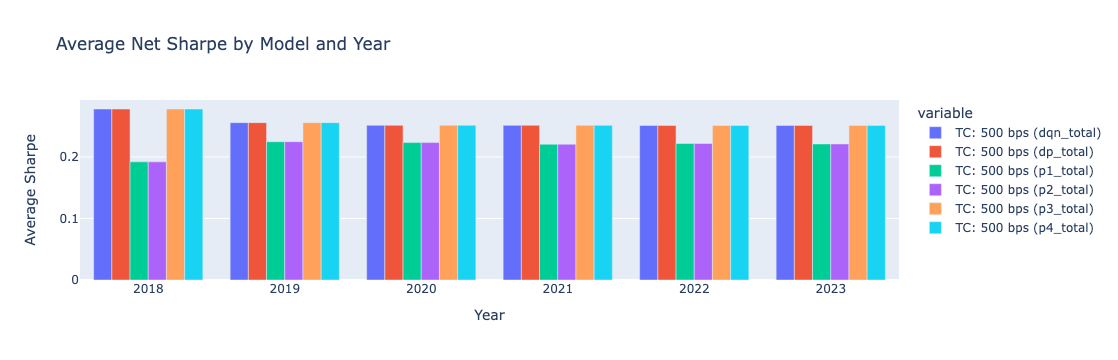

In [64]:
fig = px.bar(df_grouped_6, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year',
)

# Show the plot
fig.show()

In [65]:
dp_weights

TC: 0 bps  TC: 5 bps  TC: 10 bps  TC: 20 bps  TC: 50 bps  TC: 100 bps  \
0       0.64       0.69        0.02        0.02        0.02         0.02   
1       0.36       0.31        0.98        0.98        0.98         0.98   

   TC: 500 bps  
0         0.02  
1         0.98

<!-- DQN, Buy and Hold, Greedy policies performed the worst here with TC = 500 bps. -->

# Stats across Time

- Policy 1: Always rebalance to optimal
- Policy 2: Only rebalance if $|w^* - w_0| > 0.01$
- Policy 3: Never rebalance (buy and hold)
- Policy 4: Single period optimal (greedy) -> take $max(Sharpe(w*) - c|w^* - w_0|, Sharpe(w0))$

## Day over Day

In [66]:
tmp_series = df.mean()

# Create an empty dictionary to store the data
data_dict = {}

# Extract values and indices from the series
for index, value in tmp_series.items():
    # Split the index to get the category within the parentheses
    category = index.split('(')[-1][:-1]  # Extracts the text within the parentheses

    # Extract the first part to use as the row index
    row_index = index.split('(')[0].strip()

    # If the index is not in the dictionary, create an empty list for that index
    if row_index not in data_dict:
        data_dict[row_index] = {}

    # Store the value in the dictionary under the respective row and category
    data_dict[row_index][category] = value

In [67]:
df_mean = pd.DataFrame(data_dict).T
df_mean.style.applymap(color_positive_green)

In [68]:
end_sim_results = df[[i for i in df.columns if "_obj" in i and "p4" not in i]].mean(axis=0) - df[[i for i in df.columns if "_tc" in i and "p4" not in i]].sum(axis=0).values
end_sim_results.to_frame().T

TC: 0 bps (dqn_obj)  TC: 5 bps (dqn_obj)  TC: 10 bps (dqn_obj)  \
0             0.300463            -0.181703              0.252718   

   TC: 20 bps (dqn_obj)  TC: 50 bps (dqn_obj)  TC: 100 bps (dqn_obj)  \
0              0.252718              0.252718               0.252718   

   TC: 500 bps (dqn_obj)  TC: 0 bps (dp_obj)  TC: 5 bps (dp_obj)  \
0               0.252718            0.300463           -0.207859   

   TC: 10 bps (dp_obj)  ...  TC: 50 bps (p2_obj)  TC: 100 bps (p2_obj)  \
0             0.252718  ...           -14.048417            -28.397297   

   TC: 500 bps (p2_obj)  TC: 0 bps (p3_obj)  TC: 5 bps (p3_obj)  \
0           -143.188337            0.252718            0.252718   

   TC: 10 bps (p3_obj)  TC: 20 bps (p3_obj)  TC: 50 bps (p3_obj)  \
0             0.252718             0.252718             0.252718   

   TC: 100 bps (p3_obj)  TC: 500 bps (p3_obj)  
0              0.252718              0.252718  

[1 rows x 35 columns]

## Day over Day with cumsum TC

In [69]:
def get_result_comparison(d, old=True, by_year=False):
    if old:
        # exclude policy 4
        tc_df = d[[i for i in d if "_tc" in i and "p4" not in i]]
        obj_df = d[[i for i in d if "_obj" in i and "p4" not in i]]
    
        diff = obj_df.expanding().mean() - tc_df.cumsum().values
        diff.columns = [i.replace(f"_obj", f"_total") for i in obj_df.columns]
        p4_obj = d[[i for i in d if "_obj" in i and "p4"  in i]]
        p4_tc = d[[i for i in d if "_tc" in i and "p4"  in i]]
        p4_df = p4_obj + p4_tc.values - p4_tc.cumsum().values # p4 objective already includes cost_i or turnover cost for each day
        p4_df.columns = [i.replace(f"_obj", f"_total") for i in p4_obj.columns]
        out = pd.concat([diff, p4_df], axis=1)
        return out
    elif by_year and not old:
        tc_df = d[[i for i in d if "_tc" in i and "p4" not in i]]
        tc_df.index = pd.to_datetime(tc_df.index)
        
        obj_df = d[[i for i in d if "_obj" in i and "p4" not in i]]
        obj_df.index = pd.to_datetime(obj_df.index)
        
        diff = (obj_df.groupby([obj_df.index.year]).mean() - tc_df.groupby([tc_df.index.year]).sum().values)
        diff.columns = [i.replace(f"_obj", f"_total") for i in obj_df.columns]
        
        p4_obj = d[[i for i in d if "_obj" in i and "p4"  in i]]
        p4_obj.index = pd.to_datetime(p4_obj.index)
        
        p4_tc = d[[i for i in d if "_tc" in i and "p4"  in i]]
        p4_tc.index = pd.to_datetime(p4_tc.index)
        
        p4_df = (p4_obj + p4_tc.values).groupby(p4_obj.index.year).mean() - p4_tc.groupby([p4_tc.index.year]).sum().values # p4 objective already includes cost_i or turnover cost for each day
        p4_df.columns = [i.replace(f"_obj", f"_total") for i in p4_obj.columns]
        out = pd.concat([diff, p4_df], axis=1)
        return out

    else:
        tc_df = d[[i for i in d if "_tc" in i and "p4" not in i]]
        obj_df = d[[i for i in d if "_obj" in i and "p4" not in i]]
        
        diff = (obj_df.mean(axis=0) - tc_df.sum(axis=0).values)
        diff.index = [i.replace(f"_obj", f"_total") for i in obj_df.columns]
        p4_obj = d[[i for i in d if "_obj" in i and "p4"  in i]]
        p4_tc = d[[i for i in d if "_tc" in i and "p4"  in i]]
        p4_df = (p4_obj + p4_tc.values).mean(axis=0) - p4_tc.sum(axis=0).values # p4 objective already includes cost_i or turnover cost for each day
        p4_df.index = [i.replace(f"_obj", f"_total") for i in p4_obj.columns]
        out = pd.concat([diff, p4_df], axis=0).to_frame()
        return out
        

In [70]:
# add total objective
df_cumsum_0 = get_result_comparison(d=df_0)
df_cumsum_1 = get_result_comparison(d=df_1)
df_cumsum_2 = get_result_comparison(d=df_2)
df_cumsum_3 = get_result_comparison(d=df_3)
df_cumsum_4 = get_result_comparison(d=df_4)
df_cumsum_5 = get_result_comparison(d=df_5)
df_cumsum_6 = get_result_comparison(d=df_6)

df_list = [df_cumsum_0, df_cumsum_1, df_cumsum_2, df_cumsum_3, df_cumsum_4, df_cumsum_5, df_cumsum_6]
df_cumsum = pd.concat(df_list, axis=1).reset_index(drop=True)

df_cumsum.head().style.applymap(color_positive_green)

In [71]:
# df_mean = pd.DataFrame(data_dict).T
# df_mean.style.applymap(color_positive_green)

In [72]:
# net_sharpe(w1=np.array([0.64, 0.36]), mu=mu, cov=cov) - cost_turnover(w0=np.array([0.70, 0.30]), w1=optimal_weight, tc=0.05) * scaling_factor

In [73]:
# extract last row of simulation and see which strategy was better
tmp = df_cumsum.iloc[-1:, :].T
tmp['TC'] = tmp.index.str.extract(r'(TC: (\d+) bps)')[0].values.flatten()
tmp['models'] = tmp.index.str.extract(r'\((\w+)\)').values.flatten()

In [74]:
# Pivot the DataFrame
df_pivot = tmp.pivot(index='TC', columns='models', values=N-1)
df_pivot['sort_order'] = df_pivot.index.str.extract(r'(\d+)').astype(int).values.flatten()
df_pivot = df_pivot.sort_values(by='sort_order')
df_pivot = df_pivot.drop(columns='sort_order')

df_pivot.style.applymap(color_positive_green)

In [75]:
df_1.iloc[:, :6].cumsum()

TC: 5 bps (dqn_tc)  TC: 5 bps (dp_tc)  TC: 5 bps (p1_tc)  \
2018-11-29            0.011592           0.011592           0.011592   
2018-11-30            0.011592           0.011592           0.013104   
2018-12-01            0.011592           0.011592           0.013608   
2018-12-02            0.011592           0.011592           0.014112   
2018-12-03            0.011592           0.011592           0.014616   
...                        ...                ...                ...   
2023-11-23            0.480312           0.507024           1.430856   
2023-11-24            0.480312           0.507024           1.432368   
2023-11-25            0.480312           0.507024           1.434384   
2023-11-26            0.480312           0.507024           1.434888   
2023-11-27            0.480312           0.507024           1.434888   

            TC: 5 bps (p2_tc)  TC: 5 bps (p3_tc)  TC: 5 bps (p4_tc)  
2018-11-29           0.011592                0.0           0.011592  
2018-11-30           0.013104                0.0           0.011592  
2018-12-01           0.013608                0.0           0.011592  
2018-12-02           0.014112                0.0           0.011592  
2018-12-03           0.014616                0.0           0.011592  
...                       ...                ...                ...  
2023-11-23           1.430856                0.0           0.507024  
2023-11-24           1.432368                0.0           0.507024  
2023-11-25           1.434384                0.0           0.507024  
2023-11-26           1.434888                0.0           0.507024  
2023-11-27           1.434888                0.0           0.507024  

[1825 rows x 6 columns]

In [76]:
df_1.iloc[:, 6:12].expanding().mean()

TC: 5 bps (dqn_obj)  TC: 5 bps (dp_obj)  TC: 5 bps (p1_obj)  \
2018-11-29             0.300463            0.300463            0.300463   
2018-11-30             0.300214            0.300214            0.300463   
2018-12-01             0.300011            0.300011            0.300463   
2018-12-02             0.299798            0.299798            0.300463   
2018-12-03             0.299759            0.299759            0.300463   
...                         ...                 ...                 ...   
2023-11-23             0.298607            0.299165            0.300463   
2023-11-24             0.298608            0.299166            0.300463   
2023-11-25             0.298608            0.299166            0.300463   
2023-11-26             0.298609            0.299166            0.300463   
2023-11-27             0.298609            0.299165            0.300463   

            TC: 5 bps (p2_obj)  TC: 5 bps (p3_obj)  TC: 5 bps (p4_obj)  
2018-11-29            0.300463            0.283949            0.288871  
2018-11-30            0.300463            0.282465            0.294418  
2018-12-01            0.300463            0.281642            0.296147  
2018-12-02            0.300463            0.280986            0.296900  
2018-12-03            0.300463            0.280788            0.297441  
...                        ...                 ...                 ...  
2023-11-23            0.300463            0.252722            0.298887  
2023-11-24            0.300463            0.252721            0.298887  
2023-11-25            0.300463            0.252720            0.298888  
2023-11-26            0.300463            0.252719            0.298888  
2023-11-27            0.300463            0.252718            0.298888  

[1825 rows x 6 columns]

In [77]:
df_1.iloc[:, 6:12].ewm(alpha=0.9).mean()

TC: 5 bps (dqn_obj)  TC: 5 bps (dp_obj)  TC: 5 bps (p1_obj)  \
2018-11-29             0.300463            0.300463            0.300463   
2018-11-30             0.300011            0.300011            0.300463   
2018-12-01             0.299644            0.299644            0.300463   
2018-12-02             0.299208            0.299208            0.300463   
2018-12-03             0.299565            0.299565            0.300463   
...                         ...                 ...                 ...   
2023-11-23             0.300232            0.299925            0.300463   
2023-11-24             0.300387            0.300409            0.300463   
2023-11-25             0.299923            0.299485            0.300463   
2023-11-26             0.299436            0.298803            0.300463   
2023-11-27             0.299388            0.298735            0.300463   

            TC: 5 bps (p2_obj)  TC: 5 bps (p3_obj)  TC: 5 bps (p4_obj)  
2018-11-29            0.300463            0.283949            0.288871  
2018-11-30            0.300463            0.281250            0.298957  
2018-12-01            0.300463            0.280120            0.299540  
2018-12-02            0.300463            0.279127            0.299198  
2018-12-03            0.300463            0.279909            0.299563  
...                        ...                 ...                 ...  
2023-11-23            0.300463            0.251268            0.299925  
2023-11-24            0.300463            0.251268            0.300409  
2023-11-25            0.300463            0.251268            0.299485  
2023-11-26            0.300463            0.251268            0.298803  
2023-11-27            0.300463            0.251268            0.298735  

[1825 rows x 6 columns]

In [78]:
df_1.iloc[:, 6:12].ewm(alpha=0.9).mean() - df_1.iloc[:, :6].cumsum().values

TC: 5 bps (dqn_obj)  TC: 5 bps (dp_obj)  TC: 5 bps (p1_obj)  \
2018-11-29             0.288871            0.288871            0.288871   
2018-11-30             0.288419            0.288419            0.287359   
2018-12-01             0.288052            0.288052            0.286855   
2018-12-02             0.287616            0.287616            0.286351   
2018-12-03             0.287973            0.287973            0.285847   
...                         ...                 ...                 ...   
2023-11-23            -0.180080           -0.207099           -1.130393   
2023-11-24            -0.179925           -0.206615           -1.131905   
2023-11-25            -0.180389           -0.207539           -1.133921   
2023-11-26            -0.180876           -0.208221           -1.134425   
2023-11-27            -0.180924           -0.208289           -1.134425   

            TC: 5 bps (p2_obj)  TC: 5 bps (p3_obj)  TC: 5 bps (p4_obj)  
2018-11-29            0.288871            0.283949            0.277279  
2018-11-30            0.287359            0.281250            0.287365  
2018-12-01            0.286855            0.280120            0.287948  
2018-12-02            0.286351            0.279127            0.287606  
2018-12-03            0.285847            0.279909            0.287971  
...                        ...                 ...                 ...  
2023-11-23           -1.130393            0.251268           -0.207099  
2023-11-24           -1.131905            0.251268           -0.206615  
2023-11-25           -1.133921            0.251268           -0.207539  
2023-11-26           -1.134425            0.251268           -0.208221  
2023-11-27           -1.134425            0.251268           -0.208289  

[1825 rows x 6 columns]

## What Really Matters -> Show Professor This!!

In [79]:
# add total objective
df_result_0 = get_result_comparison(d=df_0, old=False)
df_result_1 = get_result_comparison(d=df_1, old=False)
df_result_2 = get_result_comparison(d=df_2, old=False)
df_result_3 = get_result_comparison(d=df_3, old=False)
df_result_4 = get_result_comparison(d=df_4, old=False)
df_result_5 = get_result_comparison(d=df_5, old=False)
df_result_6 = get_result_comparison(d=df_6, old=False)

df_list = [df_result_0, df_result_1, df_result_2, df_result_3, df_result_4, df_result_5, df_result_6]
df_result = pd.concat(df_list, axis=0)

df_result.T.head().style.applymap(color_positive_green)

In [80]:
# # exclude policy 4
# d = df_1.copy(deep=True)
# tc_df = d[[i for i in d if "_tc" in i and "p4" not in i]]
# obj_df = d[[i for i in d if "_obj" in i and "p4" not in i]]

# diff = (obj_df.mean(axis=0) - tc_df.sum(axis=0).values)
# diff.index = [i.replace(f"_obj", f"_total") for i in obj_df.columns]
# p4_obj = d[[i for i in d if "_obj" in i and "p4"  in i]]
# p4_tc = d[[i for i in d if "_tc" in i and "p4"  in i]]
# p4_df = (p4_obj + p4_tc.values).mean(axis=0) - p4_tc.sum(axis=0).values # p4 objective already includes cost_i or turnover cost for each day
# p4_df.index = [i.replace(f"_obj", f"_total") for i in p4_obj.columns]
# out = pd.concat([diff, p4_df], axis=0).to_frame()
# out

In [81]:
# a = weights_dqn_list["TC: 5 bps"].apply(pd.Series).loc[dqn_action[dqn_action["TC: 5 bps"] == 1].index[1:]-1]
# b = weights_dp_list["TC: 5 bps"].apply(pd.Series).loc[dp_action[dp_action["TC: 5 bps"] == 1].index[1:]-1]
# a.equals(b)

In [82]:
# pd.concat([weights_dqn_list["TC: 5 bps"].apply(pd.Series), weights_dp_list["TC: 5 bps"].apply(pd.Series)], axis=1)

In [83]:
df_result['TC'] = df_result.index.str.extract(r'(TC: (\d+) bps)')[0].values.flatten()
df_result['models'] = df_result.index.str.extract(r'\((\w+)\)').values.flatten()
# Pivot the DataFrame
df_pivot = df_result.pivot(index='TC', columns='models', values=0)
df_pivot['sort_order'] = df_pivot.index.str.extract(r'(\d+)').astype(int).values.flatten()
df_pivot = df_pivot.sort_values(by='sort_order')
df_pivot = df_pivot.drop(columns='sort_order')

df_pivot.style.applymap(color_positive_green)

0>10 bps

In [84]:
col = "TC: 5 bps"
weights_dqn_list[col].apply(pd.Series).loc[dqn_action[dqn_action[col] != dp_action[col]].index]

0     1
5     0.64  0.36
7     0.64  0.36
9     0.64  0.36
17    0.64  0.36
18    0.64  0.36
...    ...   ...
1812  0.70  0.30
1814  0.64  0.36
1816  0.64  0.36
1817  0.64  0.36
1819  0.64  0.36

[325 rows x 2 columns]

In [85]:
weights_dp_list[col].apply(pd.Series).loc[dqn_action[dqn_action[col] != dp_action[col]].index]

0     1
5     0.65  0.35
7     0.65  0.35
9     0.66  0.34
17    0.53  0.47
18    0.53  0.47
...    ...   ...
1812  0.64  0.36
1814  0.65  0.35
1816  0.65  0.35
1817  0.65  0.35
1819  0.65  0.35

[325 rows x 2 columns]

In [86]:
dqn_action[dqn_action[col] != dp_action[col]]

TC: 0 bps  TC: 5 bps  TC: 10 bps  TC: 20 bps  TC: 50 bps  TC: 100 bps  \
5             1          1           0           0           0            0   
7             1          1           0           0           0            0   
9             1          1           0           0           0            0   
17            1          1           0           0           0            0   
18            1          1           0           0           0            0   
...         ...        ...         ...         ...         ...          ...   
1812          1          0           0           0           0            0   
1814          1          1           0           0           0            0   
1816          1          1           0           0           0            0   
1817          1          1           0           0           0            0   
1819          1          1           0           0           0            0   

      TC: 500 bps  
5               0  
7               0  
9               0  
17              0  
18              0  
...           ...  
1812            0  
1814            0  
1816            0  
1817            0  
1819            0  

[325 rows x 7 columns]

TC = 5 bps:
- DP No Rebalance zone: [0.53, 0.70]
- DQN No Rebalance zon: [0.50, 0.70]

- Policy 1: Always rebalance to optimal
- Policy 2: Only rebalance if $|w^* - w_0| > 0.01$
- Policy 3: Never rebalance (buy and hold)
- Policy 4: Single period optimal (greedy) -> take $max( Sharpe(w*) - c|w^* - w_0|, Sharpe(w0))$

## By Year

In [87]:
df_grouped_year_list = [df_grouped_0, df_grouped_1, df_grouped_2, df_grouped_3, df_grouped_4, df_grouped_5, df_grouped_6]
df_grouped_year = pd.concat(df_grouped_year_list, axis=1)
df_grouped_year

TC: 0 bps (dqn_total)  TC: 0 bps (dp_total)  TC: 0 bps (p1_total)  \
2018               0.300463              0.300463              0.300463   
2019               0.300463              0.300463              0.300463   
2020               0.300463              0.300463              0.300463   
2021               0.300463              0.300463              0.300463   
2022               0.300463              0.300463              0.300463   
2023               0.300463              0.300463              0.300463   

      TC: 0 bps (p2_total)  TC: 0 bps (p3_total)  TC: 0 bps (p4_total)  \
2018              0.300463              0.277963              0.300463   
2019              0.300463              0.255778              0.300463   
2020              0.300463              0.251450              0.300463   
2021              0.300463              0.251350              0.300463   
2022              0.300463              0.251288              0.300463   
2023              0.300463              0.251317              0.300463   

      TC: 5 bps (dqn_total)  TC: 5 bps (dp_total)  TC: 5 bps (p1_total)  \
2018               0.298937              0.298371              0.299378   
2019               0.298224              0.299071              0.299706   
2020               0.298268              0.298777              0.299691   
2021               0.298368              0.299207              0.299664   
2022               0.298414              0.298550              0.299677   
2023               0.298409              0.298880              0.299669   

      TC: 5 bps (p2_total)  ...  TC: 100 bps (p1_total)  \
2018              0.299378  ...                0.278775   
2019              0.299706  ...                0.285329   
2020              0.299691  ...                0.285040   
2021              0.299664  ...                0.284500   
2022              0.299677  ...                0.284749   
2023              0.299669  ...                0.284597   

      TC: 100 bps (p2_total)  TC: 100 bps (p3_total)  TC: 100 bps (p4_total)  \
2018                0.278775                0.277963                0.277963   
2019                0.285329                0.255778                0.255778   
2020                0.285040                0.251450                0.251450   
2021                0.284500                0.251350                0.251350   
2022                0.284749                0.251288                0.251288   
2023                0.284597                0.251317                0.251317   

      TC: 500 bps (dqn_total)  TC: 500 bps (dp_total)  TC: 500 bps (p1_total)  \
2018                 0.277963                0.277963                0.192026   
2019                 0.255778                0.255778                0.224794   
2020                 0.251450                0.251450                0.223348   
2021                 0.251350                0.251350                0.220651   
2022                 0.251288                0.251288                0.221894   
2023                 0.251317                0.251317                0.221132   

      TC: 500 bps (p2_total)  TC: 500 bps (p3_total)  TC: 500 bps (p4_total)  
2018                0.192026                0.277963                0.277963  
2019                0.224794                0.255778                0.255778  
2020                0.223348                0.251450                0.251450  
2021                0.220651                0.251350                0.251350  
2022                0.221894                0.251288                0.251288  
2023                0.221132                0.251317                0.251317  

[6 rows x 42 columns]

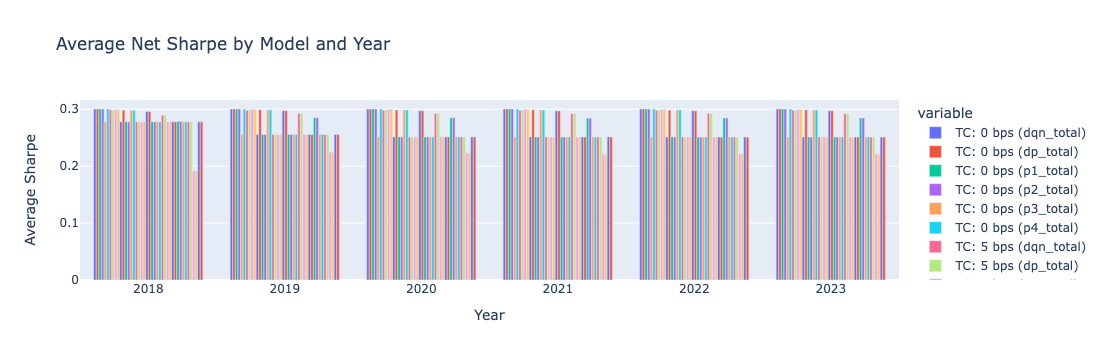

In [88]:
fig = px.bar(df_grouped_year, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

## BY Year Cumsum

In [89]:
df_cumsum.index = pd.to_datetime(df_1.index)
df_grouped_year_cumsum = df_cumsum.groupby([df_cumsum.index.year]).last()
df_grouped_year_cumsum.head()

TC: 0 bps (dqn_total)  TC: 0 bps (dp_total)  TC: 0 bps (p1_total)  \
2018               0.300463              0.300463              0.300463   
2019               0.300463              0.300463              0.300463   
2020               0.300463              0.300463              0.300463   
2021               0.300463              0.300463              0.300463   
2022               0.300463              0.300463              0.300463   

      TC: 0 bps (p2_total)  TC: 0 bps (p3_total)  TC: 0 bps (p4_total)  \
2018              0.300463              0.277963              0.300463   
2019              0.300463              0.257618              0.300463   
2020              0.300463              0.254663              0.300463   
2021              0.300463              0.253592              0.300463   
2022              0.300463              0.253029              0.300463   

      TC: 5 bps (dqn_total)  TC: 5 bps (dp_total)  TC: 5 bps (p1_total)  \
2018               0.278410              0.281266              0.264679   
2019               0.190698              0.182881             -0.011513   
2020               0.067746              0.061826             -0.293753   
2021              -0.017926             -0.028311             -0.585065   
2022              -0.104598             -0.141312             -0.871841   

      TC: 5 bps (p2_total)  ...  TC: 100 bps (p1_total)  \
2018              0.264679  ...               -0.415217   
2019             -0.011513  ...               -5.939057   
2020             -0.293753  ...              -11.583857   
2021             -0.585065  ...              -17.410097   
2022             -0.871841  ...              -23.145617   

      TC: 100 bps (p2_total)  TC: 100 bps (p3_total)  TC: 100 bps (p4_total)  \
2018               -0.415217                0.277963                0.272352   
2019               -5.939057                0.257618                0.251268   
2020              -11.583857                0.254663                0.251268   
2021              -17.410097                0.253592                0.251916   
2022              -23.145617                0.253029                0.251268   

      TC: 500 bps (dqn_total)  TC: 500 bps (dp_total)  TC: 500 bps (p1_total)  \
2018                 0.277963                0.277963               -3.277937   
2019                 0.257618                0.257618              -30.897137   
2020                 0.254663                0.254663              -59.121137   
2021                 0.253592                0.253592              -88.252337   
2022                 0.253029                0.253029             -116.929937   

      TC: 500 bps (p2_total)  TC: 500 bps (p3_total)  TC: 500 bps (p4_total)  
2018               -3.277937                0.277963                0.272352  
2019              -30.897137                0.257618                0.251268  
2020              -59.121137                0.254663                0.251268  
2021              -88.252337                0.253592                0.251916  
2022             -116.929937                0.253029                0.251268  

[5 rows x 42 columns]

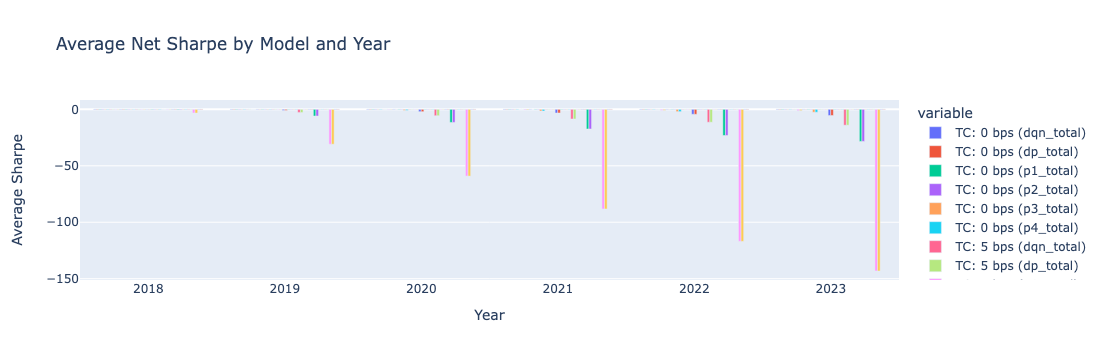

In [90]:
fig = px.bar(df_grouped_year_cumsum, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

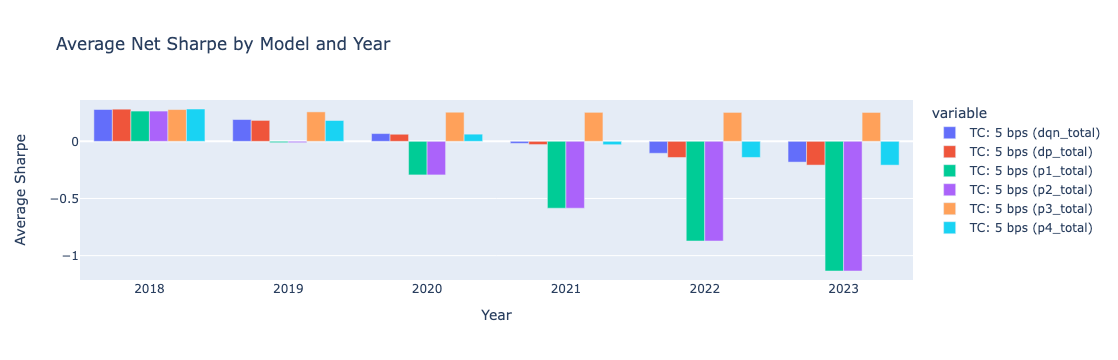

In [91]:
fig = px.bar(df_grouped_year_cumsum.iloc[:, 6:12], barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

## By Year What Really Matters

In [92]:
# add total objective
df_result_0 = get_result_comparison(d=df_0, by_year=True, old=False)
df_result_1 = get_result_comparison(d=df_1, by_year=True, old=False)
df_result_2 = get_result_comparison(d=df_2, by_year=True, old=False)
df_result_3 = get_result_comparison(d=df_3, by_year=True, old=False)
df_result_4 = get_result_comparison(d=df_4, by_year=True, old=False)
df_result_5 = get_result_comparison(d=df_5, by_year=True, old=False)
df_result_6 = get_result_comparison(d=df_6, by_year=True, old=False)

df_list = [df_result_0, df_result_1, df_result_2, df_result_3, df_result_4, df_result_5, df_result_6]
df_result = pd.concat(df_list, axis=1)

df_result.head().style.applymap(color_positive_green)

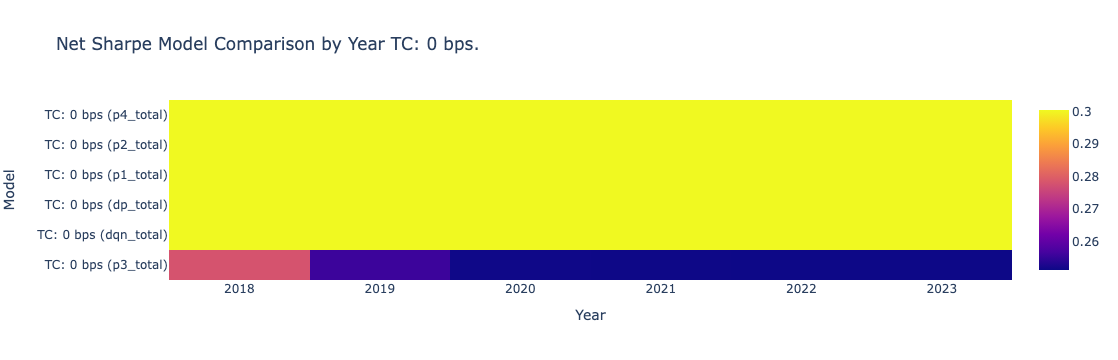

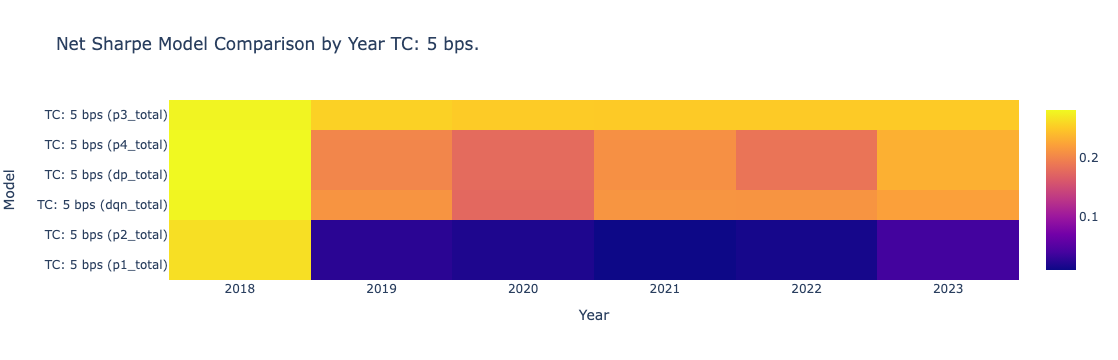

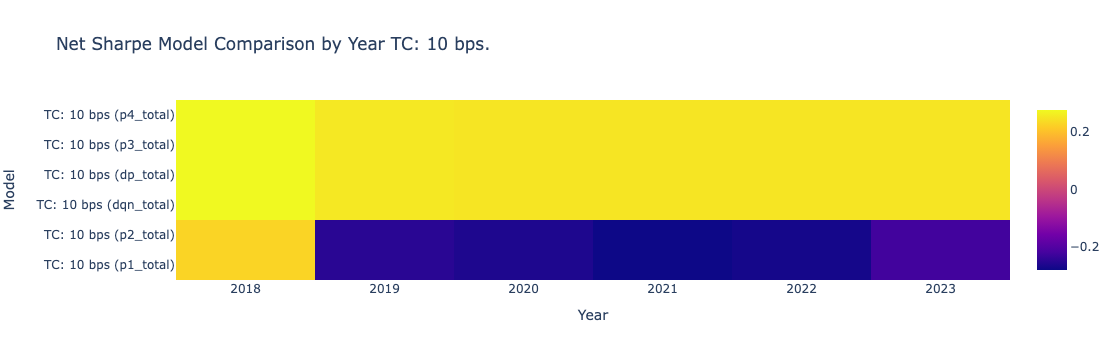

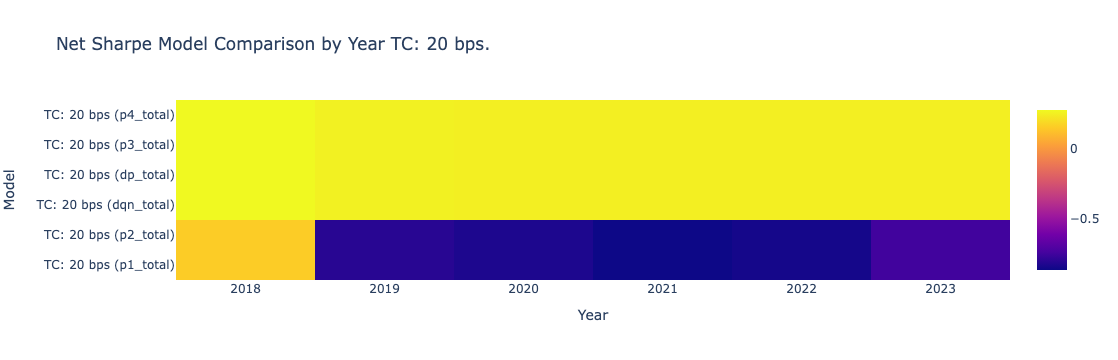

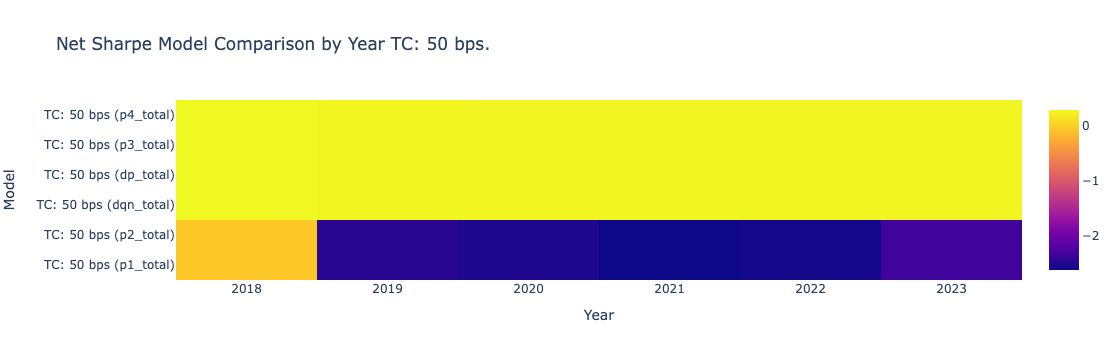

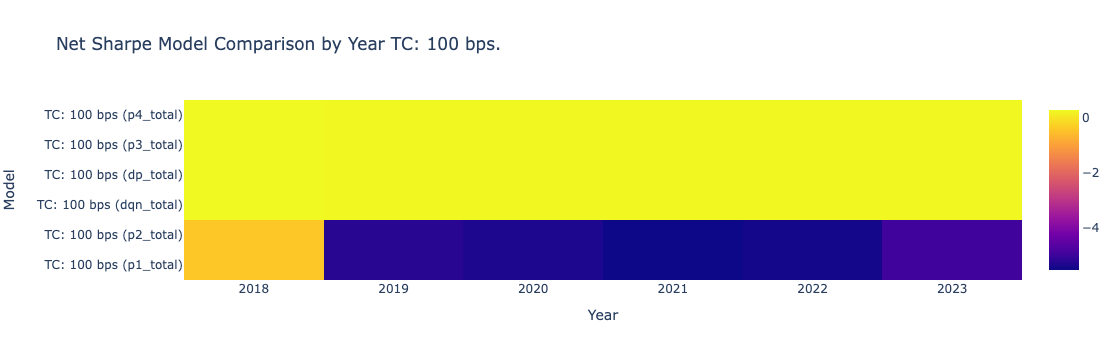

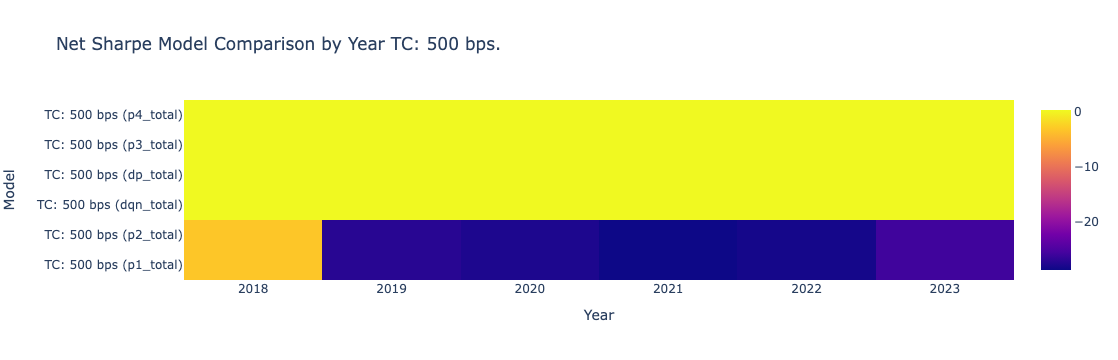

In [93]:
# Create a heatmap trace for DP Bellman
for tc in tc_list:
    tmp_df = df_result[[i for i in df_result.columns if f"TC: {tc * 1e4:.0f} bps" in i]].copy(deep=True).T
    tmp_df = tmp_df.sort_values([2023], ascending=True)
    trace_dp = go.Heatmap(z=tmp_df, x=tmp_df.columns, y=tmp_df.index, name="Model Year Performance (Net Sharpe)")
    
    # Create the layout with 'overlay' parameter set to "overlay"
    layout = go.Layout(
        title=f"Net Sharpe Model Comparison by Year TC: {tc * 1e4:.0f} bps.",
        xaxis=dict(title="Year",
                   showgrid=True),
        yaxis=dict(title="Model",
                   showgrid=True),
        # barmode="overlay"  # Set the barmode to overlay
    )
    
    
    # Create the figure
    fig = go.Figure(data=[trace_dp], layout=layout)
    fig.show()

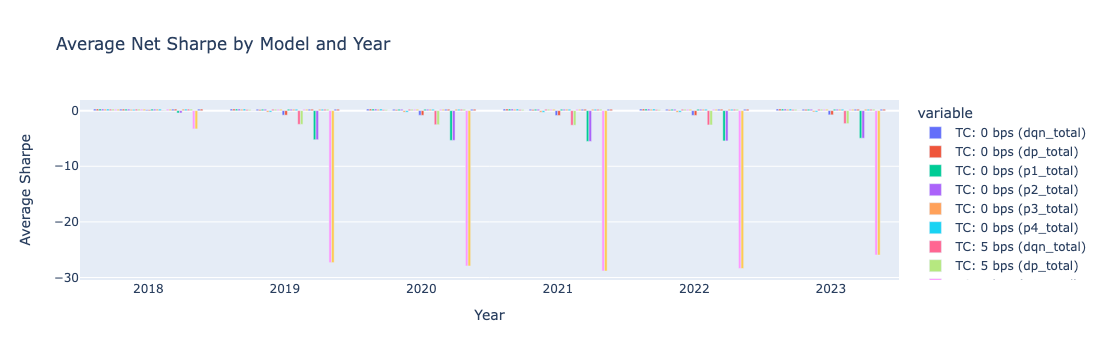

In [94]:
fig = px.bar(df_result, barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

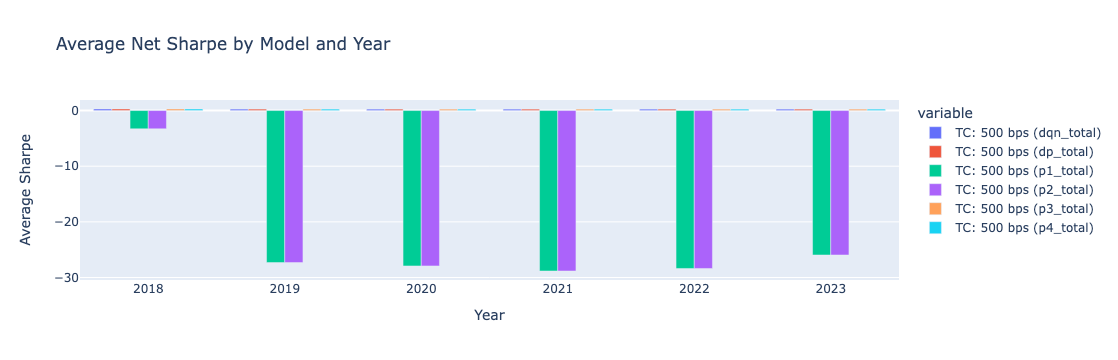

In [95]:
fig = px.bar(df_result.iloc[:, -6:], barmode='group',
             title='Average Net Sharpe by Model and Year')

# Update layout
fig.update_layout(
    yaxis_title='Average Sharpe',
    xaxis_title='Year'
)

# Show the plot
fig.show()

# Visualize Asset Returns

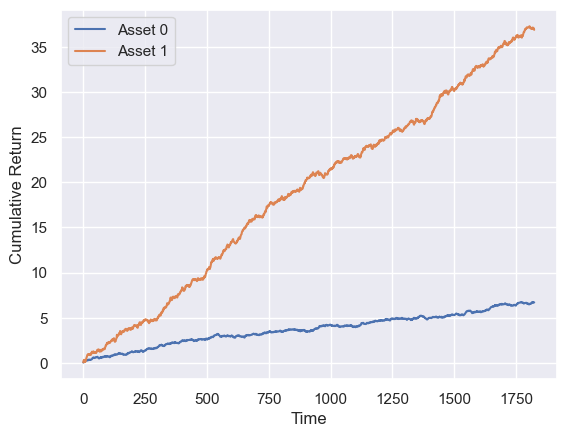

In [96]:
ret_df = pd.DataFrame(asset_returns, columns=['Asset 0', 'Asset 1'])
ret_df.index.name = "Time"
ret_df.cumsum().plot()
plt.ylabel("Cumulative Return")
plt.show()

<Axes: ylabel='Density'>

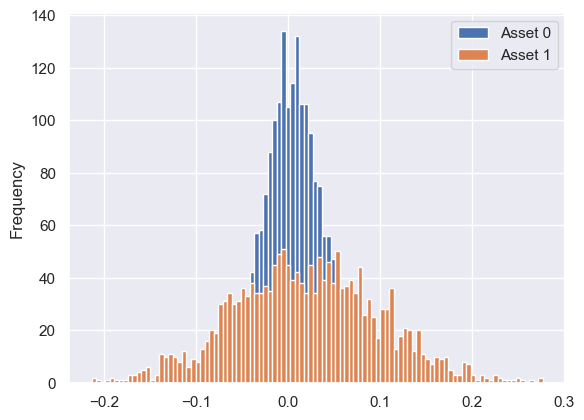

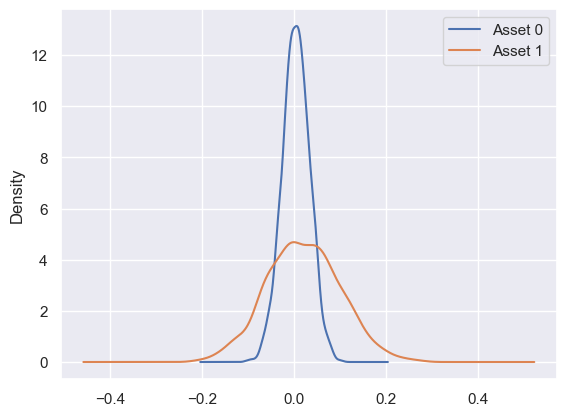

In [97]:
ret_df.plot(kind='hist', bins=100)
ret_df.plot(kind='kde')


In [98]:
ret_df.describe()

Asset 0      Asset 1
count  1825.000000  1825.000000
mean      0.003664     0.020216
std       0.029597     0.079798
min      -0.102409    -0.213457
25%      -0.016059    -0.034559
50%       0.003487     0.018751
75%       0.023544     0.074011
max       0.101586     0.276786

In [99]:
ret_df.cov()

Asset 0   Asset 1
Asset 0  0.000876  0.000068
Asset 1  0.000068  0.006368

In [100]:
mu, cov

(array([0.005, 0.02 ]),
 array([[0.0009, 0.    ],
        [0.    , 0.0064]]))

# Archives

In [101]:
def clean_ret_df(x):
    d = x.copy(deep=True)
    tmp_df = pd.DataFrame()
    for col in d.columns:
        d[col] = d[col].apply(lambda x: x.tolist())

    for col in d.columns:
        tmp_df = pd.concat([tmp_df, d[col].apply(pd.Series)], axis=1)

    column_names = []
    for col in d.columns:
        column_names.append(f"A0 - {col}")
        column_names.append(f"A1 - {col}")
    tmp_df.columns = column_names
    return  tmp_df

In [102]:
def get_ret_df(x, name):
    tmp_df = clean_ret_df(x)

    ret_df_rep = pd.DataFrame()
    for _ in range(tmp_df.shape[1]//2):
        ret_df_rep = pd.concat([ret_df_rep, ret_df], axis=1)
    
    ret_tmp_df = ret_df_rep.values * tmp_df

    output = pd.DataFrame()
    for i in range(0, ret_df_rep.shape[1]-1, 2):
        output = pd.concat([output, ret_tmp_df.iloc[:, i:i+2].sum(axis=1)], axis=1)
    output.columns = [f"{name} - TC: {i * 1e4:.0f} bps" for i in tc_list]
    return output

In [103]:
ret_p1_df = get_ret_df(weights_p1_list, name="P1")
ret_p2_df = get_ret_df(weights_p2_list, name="P2")
ret_p3_df = get_ret_df(weights_p3_list, name="P3")
ret_p4_df = get_ret_df(weights_p4_list, name="P4")
ret_dp_df = get_ret_df(weights_dp_list, name="DP")
ret_dqn_df = get_ret_df(weights_dqn_list, name="DQN")

In [104]:
# px.line(ret_df.cumsum())
# px.line(ret_p1_df.cumsum())
# px.line(ret_p2_df.cumsum())
# px.line(ret_p3_df.cumsum())
# px.line(ret_p4_df.cumsum())
# px.line(ret_dp_df.cumsum())
# px.line(ret_dqn_df.cumsum())

In [105]:
# import plotly.graph_objects as go

# fig = go.Figure()

# # Iterate through each DataFrame and its columns to add traces for each column
# for df in [ret_p1_df, ret_p2_df, ret_p3_df, ret_p4_df, ret_dp_df, ret_dqn_df]:
#     for column in df.columns:
#         fig.add_trace(go.Scatter(x=df.index, y=df[column].cumsum(), name=column))

# # Show the figure
# fig.update_layout(dict(
#     title="Cumulative return for each strategy",
#     xaxis = dict(title="Day"),
#     yaxis = dict(title="Return")
# ))
# fig.show()


In [106]:
# df

- Annual bar chart of sharpe

- Policy 1: Always rebalance to optimal
- Policy 2: Only rebalance if $|w^* - w_0| > 0.01$
- Policy 3: Never rebalance (buy and hold)
- Policy 4: Single period optimal (greedy) -> take $min(c|w^* - w_0| + Sharpe(w*), Sharpe(w_0))$

In [107]:
# risk free rate
# r = 0.05

In [108]:
# # penalize for transaction TODO
# # align with objective function
# sr_p1 = (ret_p1_df.mean() - r) / ret_p1_df.std()
# sr_p2 = (ret_p2_df.mean() - r) / ret_p2_df.std()
# sr_p3 = (ret_p3_df.mean() - r) / ret_p3_df.std()
# sr_p4 = (ret_p4_df.mean() - r) / ret_p4_df.std()
# sr_dp = (ret_dp_df.mean() - r) / ret_dp_df.std()
# sr_dqn = (ret_dqn_df.mean() - r) / ret_dqn_df.std()

In [109]:
# sr_df = pd.DataFrame()
# for d in [sr_p1, sr_p2, sr_p3, sr_p4, sr_dp, sr_dqn]:
#     sr_df = pd.concat([sr_df, d], axis=0)
# sr_df.columns = [f'Sharpe Ratio r = {r}']

In [110]:
# sr_df.sort_values(by=[f'Sharpe Ratio r = {r}'], ascending=False).head(100)